
Simple RNN
In ths notebook, we're going to train a simple RNN to do time-series prediction. Given some set of input data, it should be able to generate a prediction for the next time step! <img src='assets/time_prediction.png' width=40% />

First, we'll create our data
Then, define an RNN in PyTorch
Finally, we'll train our network and see how it performs

# Simple time series prediction 

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

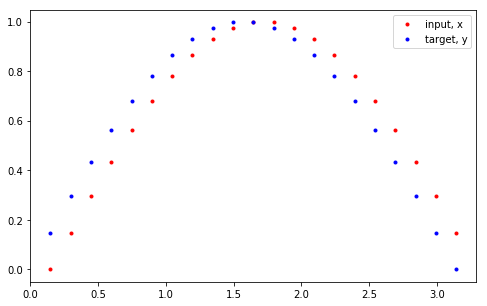

In [5]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 21

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()


Define the RNN
Next, we define an RNN in PyTorch. We'll use nn.RNN to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:

input_size - the size of the input
hidden_dim - the number of features in the RNN output and in the hidden state
n_layers - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
batch_first - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)
Take a look at the RNN documentation to read more about recurrent layers.

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        print(r_out.shape,hidden.shape)
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

Check the input and output dimensions
As a check that your model is working as expected, test out how it responds to input data.

In [7]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 21, 1])
torch.Size([21, 10]) torch.Size([2, 1, 10])
Output size:  torch.Size([21, 1])
Hidden state size:  torch.Size([2, 1, 10])


Training the RNN¶
Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

In [12]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=3

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

In [13]:

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)


Defining the training function
This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

Hidden State
Pay close attention to the hidden state, here:

Before looping over a batch of training data, the hidden state is initialized
After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

In [14]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.3598879277706146


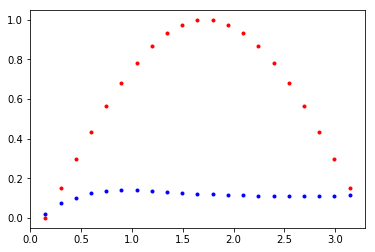

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  2.481370449066162


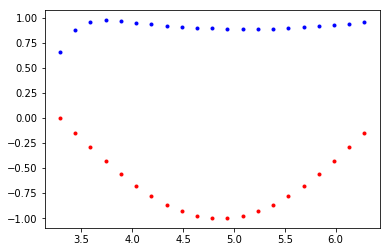

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.10801263898611069


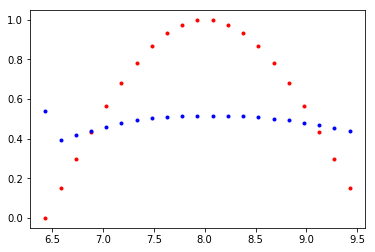

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.7012920379638672


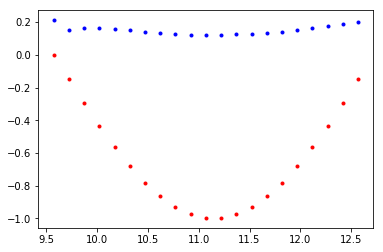

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.37558525800704956


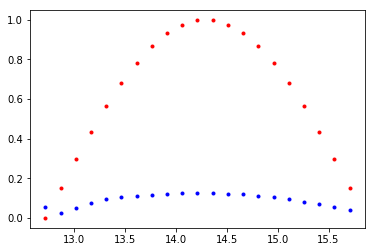

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.36721858382225037


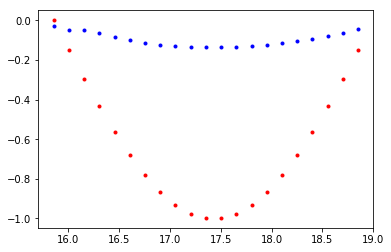

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.3938853442668915


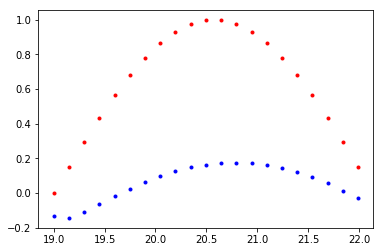

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.12075658142566681


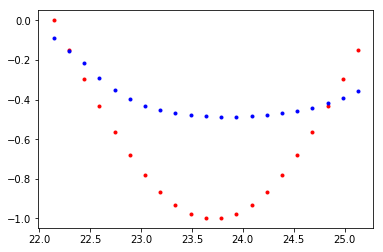

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.270967960357666


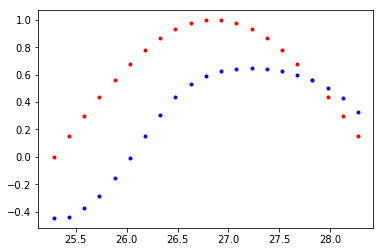

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.08713043481111526


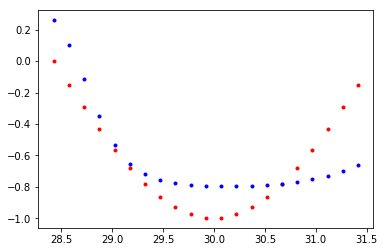

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.20119254291057587


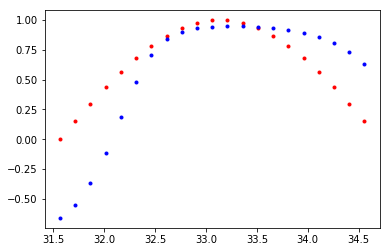

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.07935681939125061


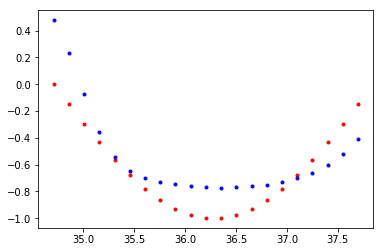

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.030269954353570938


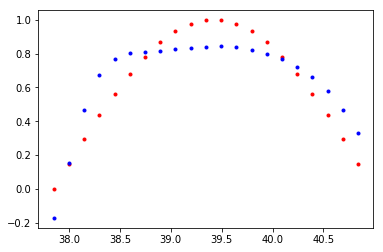

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.1469518542289734


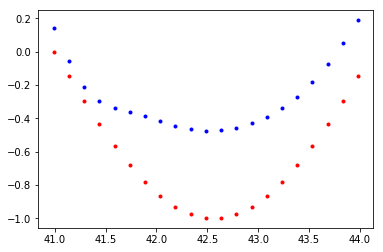

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.023081058636307716


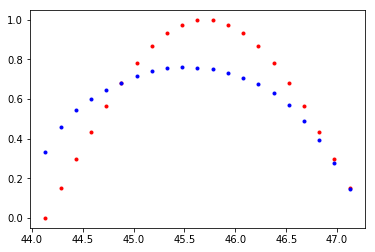

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.05425969883799553


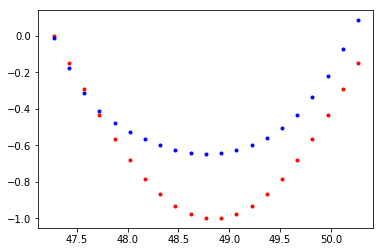

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.006261967588216066


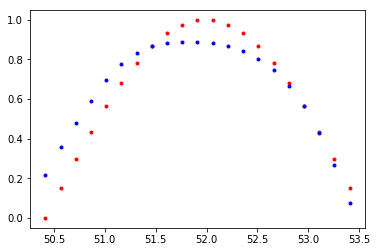

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.03247959166765213


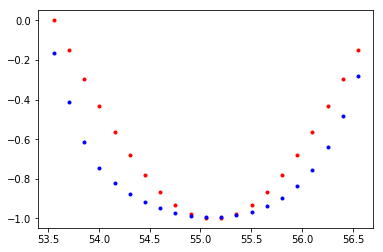

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.010924499481916428


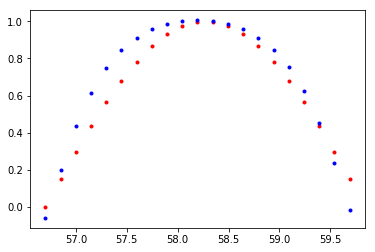

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.07309181988239288


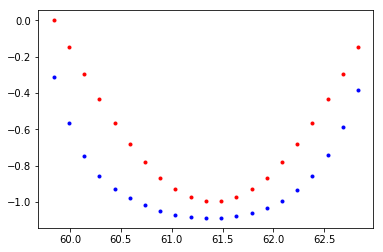

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.006535633001476526


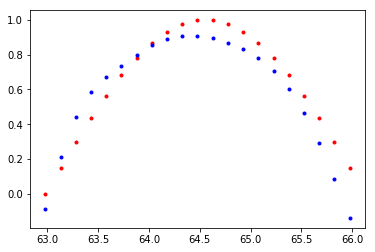

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.01855018362402916


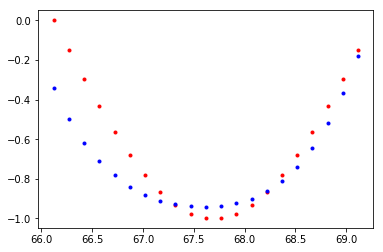

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.023775614798069


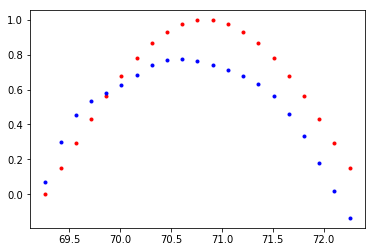

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.013918361626565456


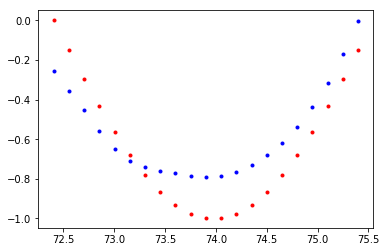

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.016995247453451157


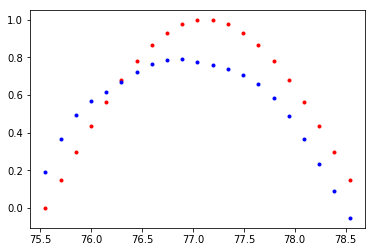

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.013833628036081791


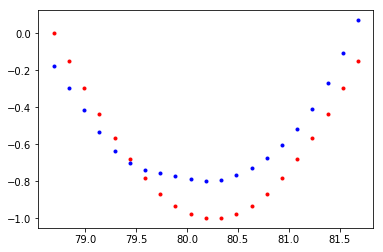

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.006219762377440929


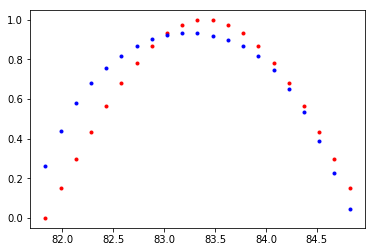

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0028601931408047676


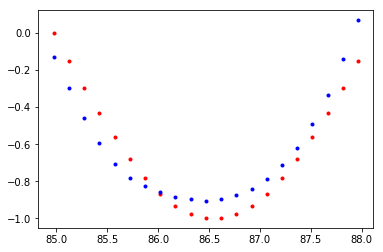

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.025816718116402626


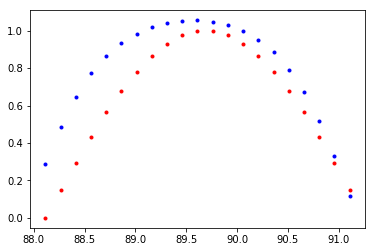

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.00414247578009963


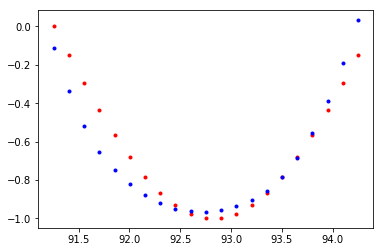

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.01721036806702614


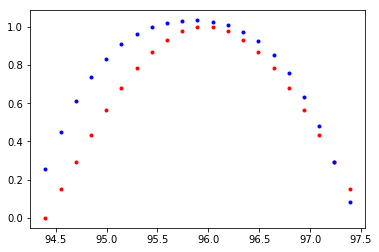

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.00323848775587976


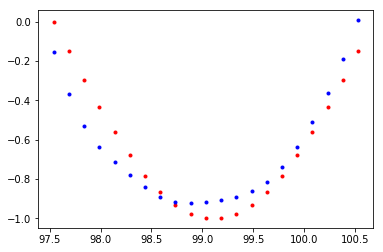

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0027904007583856583


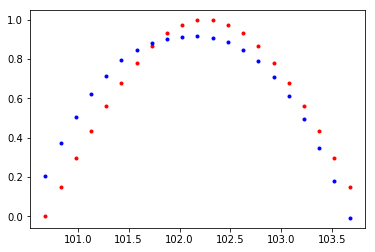

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.005886738654226065


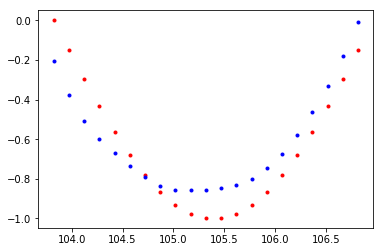

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.008890576660633087


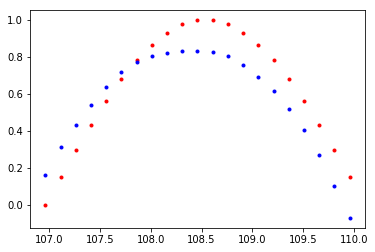

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0061535341665148735


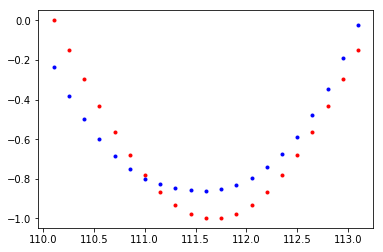

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.007223912514746189


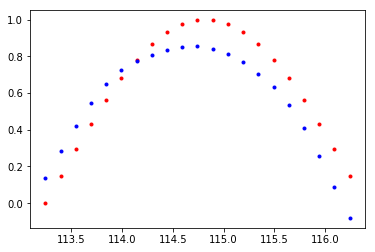

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.004728369880467653


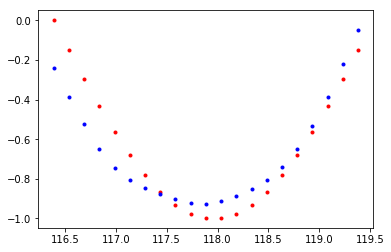

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0015890105860307813


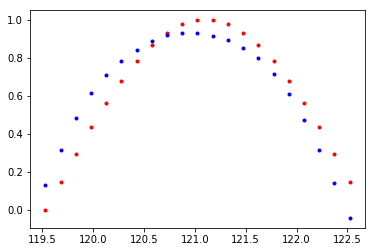

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.006539917550981045


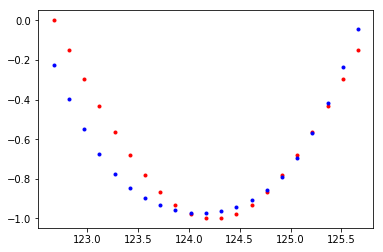

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.004101812373846769


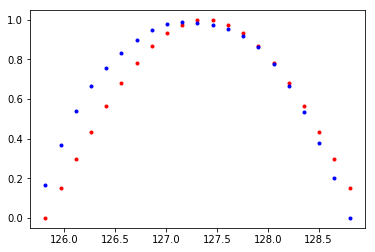

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0036659829784184694


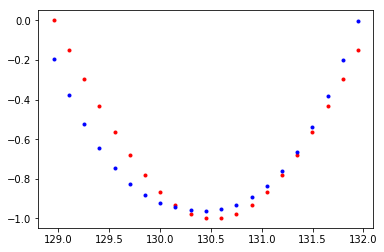

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.004126342944800854


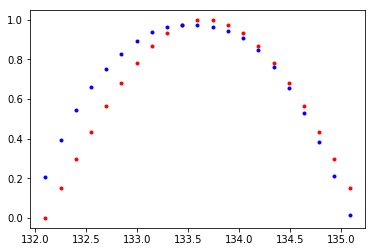

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.002656172262504697


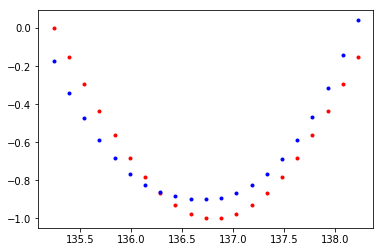

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0025543689262121916


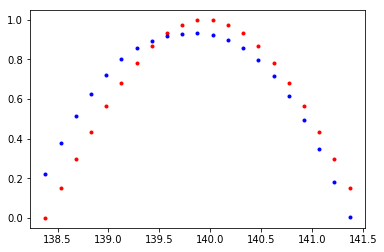

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.00512944208458066


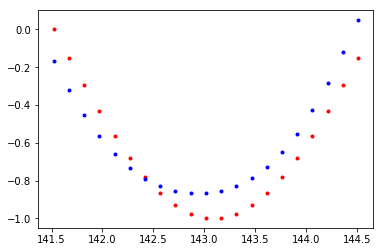

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0022871801629662514


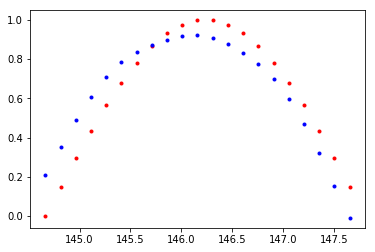

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.003041609888896346


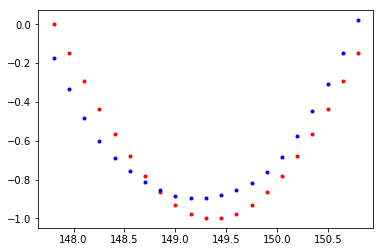

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0015297040808945894


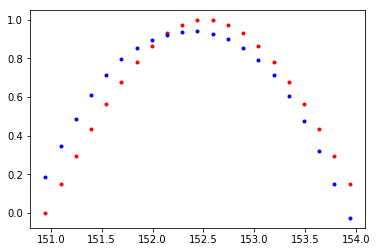

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0027800998650491238


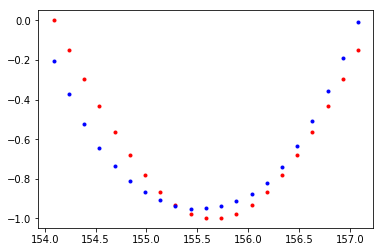

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0013995589688420296


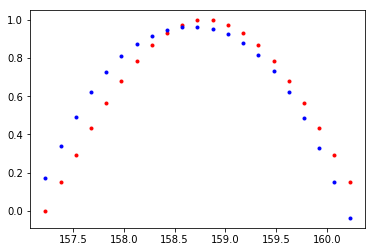

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.004300564993172884


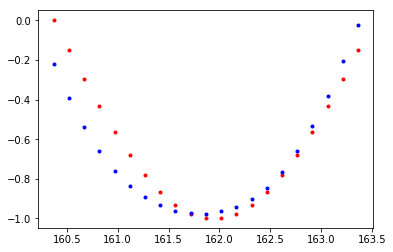

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0012162112398073077


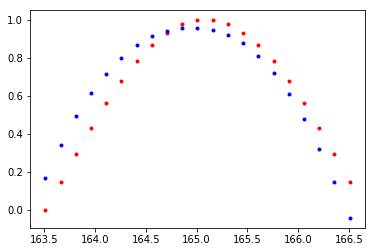

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.002512603998184204


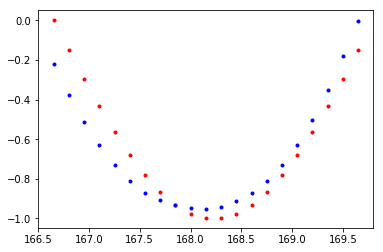

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0013676573289558291


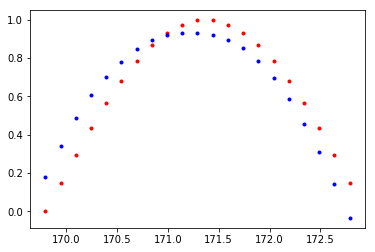

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0022299555130302906


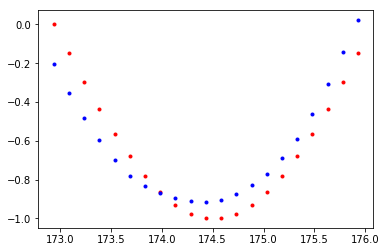

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0015540445456281304


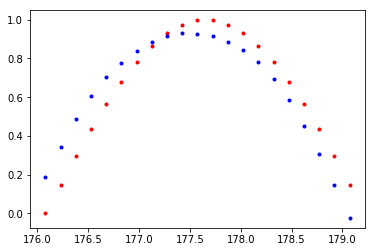

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0021670162677764893


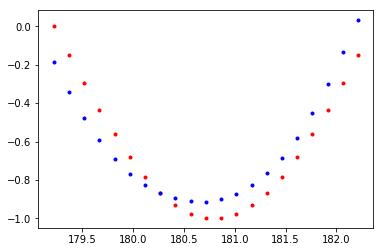

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0014267638325691223


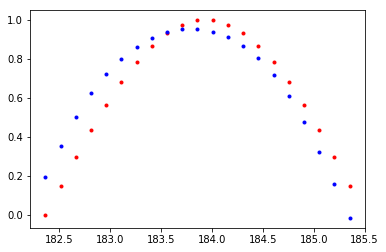

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0014594829408451915


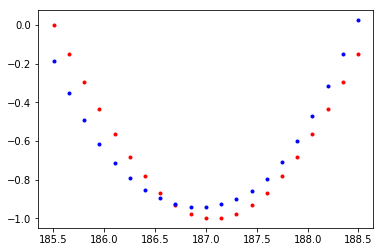

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0018659231718629599


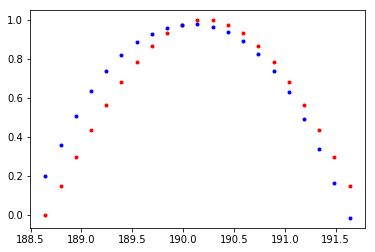

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0016929417615756392


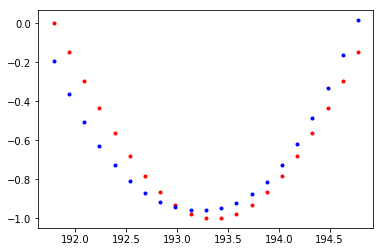

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0013736530672758818


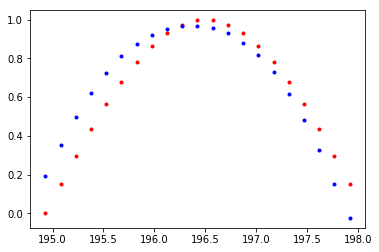

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.001596053596585989


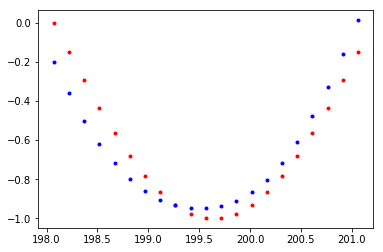

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.001060319016687572


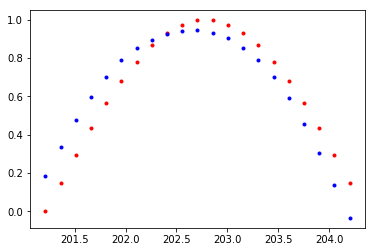

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.001629844307899475


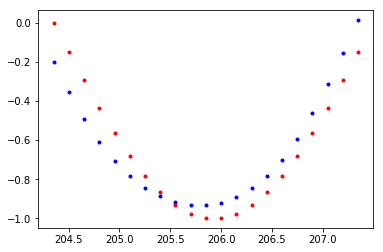

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0011739787878468633


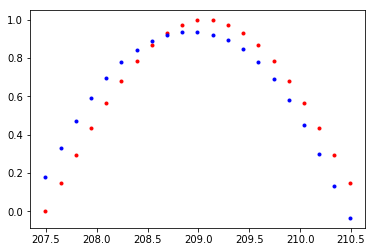

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0014955773949623108


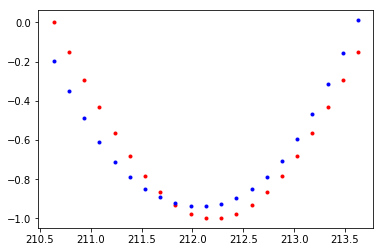

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0009261789964511991


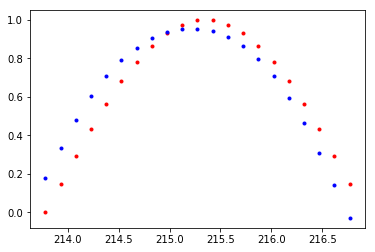

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0013818960869684815


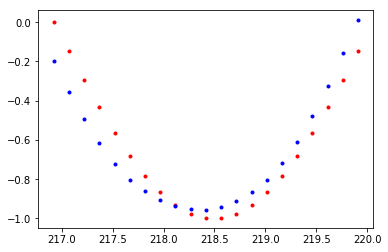

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0011429062578827143


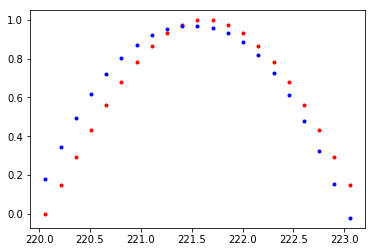

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.001276144408620894


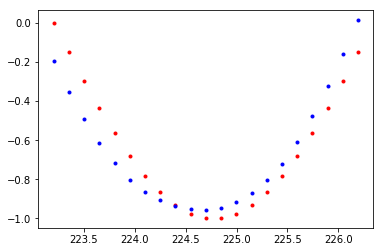

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0010607745498418808


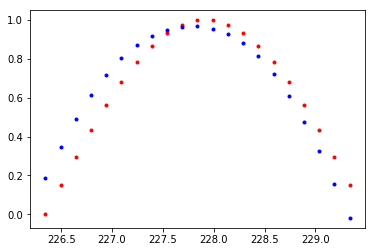

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0011985399760305882


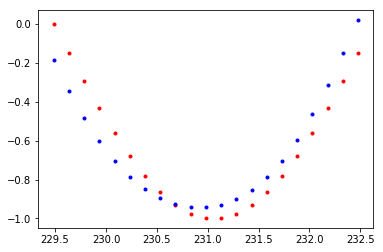

torch.Size([21, 32]) torch.Size([3, 1, 32])
Loss:  0.0008903295965865254


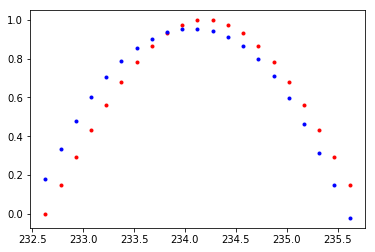

In [15]:

# train the rnn and monitor results
n_steps = 75
print_every = 1

trained_rnn = train(rnn, n_steps, print_every)